In [1]:
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp


In [1]:
%%writefile group_w_pop_funs.py
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *


def group_formation_model_non_dim(T, f_of_x_vec,N1,N2, params):
    '''
    the full system of balance equations for x = 1,2,3,...,x_max, non-dimensionalized
    @inputs:
    T - scaled time, necessary for running with solve_ivp
    f_of_x_vec - a vector of the (scaled) number of groups of 
            size 1, 2, 3, ..., x_max (maximum group size)
    P, N1, N2 - scaled population size of predators, big prey, small prey, respectivel
    if_groups_change = Bool, True --> preds can join/leave groups. 
                            False --> only birth/death affect group sizes
    params - is a dictionary of the parameters that must contain: 
            β1, β2, A1, H1, H2, η1, η2, α1_of_1, α2_of_1, s1, s2, limited_portions, 
            Tx, d, r, γ, pop_process
    @ returns
    df_dT for x = 1, 2, ..., xmax
    '''
    x_max = params['x_max']; Tx = params['Tx']; 
    d = params['d']; 
    f_of_x_vec = np.append(f_of_x_vec,0) # so can find dfdt at x = x_max

    def f(x):
        return f_of_x_vec[x-1]
    def S(x,y):
        return best_response_fun_given_fitness(x,y,fitnessvec,d)
    def ψ(x):
        # rate of joining
        f_of_1 = f_of_x_vec[0]
        if x== 1 and f_of_1 >=1:
            return f_of_1 * S(2,1)#( ξ *f_of_1 - 1) * S(2,1)
        elif x == 1 and f_of_1 < 1:
            return f_of_1 * S(2,1)
        elif x <= x_max - 1:
            return f_of_1*S(x+1,1)
        else:
            return 0
    def fun_deaths(x):
        return tildeδ * Tx * ( - x * f(x) + (x+1) * f(x+1) )
    def ϕ(x):
        return x*S(1,x) if x <= x_max else 0
    
    xvec = np.arange(1,x_max+1,1)
    # it \tau_x > 0make population matrix = birth matrix + death matrix
    fitnessvec = fitness_from_prey_non_dim(xvec, N1, N2, **params)
    dfdT_vec = np.zeros(x_max)

    # births and deaths
    if params['pop_process']:
        η1 = params['η1']; η2 = params['η2']; tildeδ = 1 - η1 - η2
        π_vec = yield_from_prey_non_dim(xvec, N1, N2, **params)
        births_vec = Tx*f_of_x_vec[:-1]* π_vec
        births_vec = np.append(births_vec,0) # so can calculate births at x_max
        deaths_vec = [fun_deaths(x) for x in range(1,x_max+1)]
    else:
        π_vec = np.zeros(fitnessvec.shape)
        births_vec = π_vec.copy()
        births_vec = np.append(births_vec,0) # so can calculate births at x_max
        deaths_vec = π_vec.copy()

    # balance equations
    for x in xvec:
        if x == 1:
            Q_1 = 2*f(2)*ϕ(2) + np.sum([f(y) * ϕ(y) for y in range(3,x_max+1)]) \
                    - sum([f(y-1)*ψ(y-1) for y in range(2,x_max+1)])
            births1 = births_vec[x_max-1] - births_vec[0]
            dfdT = (Q_1 + births1 + deaths_vec[0])/Tx
        elif x == 2:
            Q_2 = -f(2)*ϕ(2) - f(2)*ψ(2) + 0.5*f(1)*ψ(1) + f(3)*ϕ(3)
            births2 = births_vec[0] - births_vec[1]
            dfdT = (Q_2 + births2 + deaths_vec[1])/Tx
        else:
            Q_x = -f(x)*ϕ(x) - f(x) * ψ(x) + f(x-1)*ψ(x-1) + f(x+1)*ϕ(x+1)
            
            birthsx = births_vec[x-2] - births_vec[x-1] if x < x_max else births_vec[x-2]
            dfdT = (Q_x + birthsx + deaths_vec[x-1])/Tx
        
        dfdT_vec[x-1] = dfdT
        
    return dfdT_vec
    

def fun_leave_group(x, fitnessvec, x_max, d):
    '''
    The probability an individual leaves a group of size x. ϕ(x) in the text
    @inputs
    x - current grp size (before leaving)
    fitnessvec = vector of fitnesses for each group size
    x_max - parameter, maximum group size
    d = parameter determining steepness of best response function

    @ example:
    >> fitnessvec = array([0.24166667, 0.45833333, 0.53055556])
    >> fun_leave_group(xvec=[1,2,3], fitnessvec, x_max=3, d=100)
    array([0.5       , 0.03915869, 0.01923075])
    '''
    # deciding between being alone and staying in group of size x
    return best_response_fun_given_fitness(1,x,fitnessvec,d)

def best_response_fun_given_fitness(x,y,fitnessvec, d):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    fitnessvec - vector of fitnesses fro x = 1, 2, ..., xmax
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model 
    @returns:
    float between 0 and 1
    '''
    W_of_x = fitnessvec[x-1]
    W_of_y = fitnessvec[y-1]
    W_min = min(W_of_x, W_of_y)
    W_max = max(W_of_x, W_of_y)
    if W_max > 0:
        numerator = (W_of_x/W_max)**d
    else:
        return 0
    denominator = 1 + (W_min/W_max)**d # this adjustment helps avoid dividing by zero from numpy rounding
    return numerator/denominator
    
    # if W_of_x**d + W_of_y**d < 1e-100: # note that then at this point it will be 
    #                                     #rounded to 0, 
    #                                     # but since W_of_y**d must be less than 1e-300, 
    #                                     # can approximate as 1 - (W(y)/W(x))**d
    #     # option 1: both W_of_x and W_of_y are really really small
    #     # option 2: both are really small, but one is much bigger than the other
    #     # scale the smaller 1:
    #     W_min = min(W_of_x, W_of_y)
    #     W_max = max(W_of_x, W_of_y)
    #     numerator = (W_of_x/W_max)**d
    #     denominator = 1 + (W_min/W_max)**d
    #     return numerator/denominator
    # else:
    #     return W_of_x**d/(W_of_x**d + W_of_y**d)
    
def best_response_fun(x,y, N1,N2, d, **params):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    N1, N2 - big prey and small prey scaled pop size
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model
    @returns:
    float between 0 and 1
    
    '''
    
    W_of_x = fitness_from_prey_non_dim(x, N1, N2, **params)
    W_of_y = fitness_from_prey_non_dim(y, N1, N2, **params)

    W_min = min(W_of_x, W_of_y)
    W_max = max(W_of_x, W_of_y)
    if W_max > 0:
        numerator = (W_of_x/W_max)**d
    else:
        return 0
    denominator = 1 + (W_min/W_max)**d

    return W_of_x**d/(W_of_x**d + W_of_y**d)

    
def check_at_equilibrium(final_distribution, P, N1, N2,**params):
    '''
    check df(x)/dT \approx 0
    @ returns: array dfdT_, and 1 if at equilibrium or 0 if not
    '''
    T = 1 # this doesn't matter
    dfdT_ = group_formation_model_non_dim(T, final_distribution,N1,N2, params)
    not_at_equilibrium = np.abs(dfdT_) > 1e-8
    if sum(not_at_equilibrium) > 0: # at least one df(x)/dt is not zero
        return dfdT_, 0
    else:
        return dfdT_, 1

def model_one_x(T, initialstate, x, params):
    '''
    Find the time derivatives of P, N1, N2, with x fixed
    initialstate = P, N1, N2

    Here I need non-dimed F
    '''
    initialstate = np.array(initialstate)
    initialstate[np.abs(initialstate)<1e-11] = 0
    P, N1, N2 = initialstate
    F_of_x_vec = np.zeros(params['x_max'])
    F_of_x = P/x
    F_of_x_vec[x-1] = F_of_x
    dPdT = fun_dPdT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(N1, N2, F_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(N1, N2, F_of_x_vec, **params)
    return [dPdT, dN1dT, dN2dT]



def full_model(T, initialstate, arg, params):
    '''
    removed P!
    gets the time derivatives for N1, N2, f(1), f(2), ..., f(xm)
    @inputs
    T is just used by fsolve, not needed
    intiialstate = [N1,N2,*f_of_x]
    arg is a dummy because fsolve gets weird if there is only 1 arg?
    params is dictionary of params
    @ returns [dN1dT, dN2dT, *dfdT_vec]
    '''
    # i put arg there as a place holder because somehow makes ivp_solver work
    
    initialstate = np.array(initialstate)

    # this helps for numpy issues
    initialstate[np.abs(initialstate)<1e-11] = 0
    
    N1,N2 = initialstate[0:2]
    f_of_x_vec = initialstate[2:]
    #dPdT = fun_dPdT_non_dim(P, N1, N2, f_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(N1, N2, f_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(N1, N2, f_of_x_vec, **params)
    dfdT_vec = group_formation_model_non_dim(T, f_of_x_vec,N1,N2, params)
    # if if_groups_change:
    #     dfdT_vec = group_formation_model_non_dim(T, f_of_x_vec,N1,N2, 
    #                                              if_groups_change, params)
    # else:
    #     x = np.argwhere(f_of_x_vec>0)[0][0] + 1
    #     dfdT_vec = np.zeros(params['x_max'])
    #     dfdT_vec[x-1] = dPdT/x
    

    return [dN1dT, dN2dT, *dfdT_vec]

def nullclines_no_P(initialstate, params):
    '''
    returns the nullclines for N1, N2, f(1), f(2), ..., f(x_max)
    such that N1, N2 \neq 0
    @inputs
    initialstate = [N1, N2, f(1), ..., f(x_max)], type ndarray
    params = dictionary of params
    '''
    N1 = initialstate[0]
    N2 = initialstate[1]
    f_of_x_vec = initialstate[2:]

    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)


    
    

    N1_null, N2_null = N_nullclines(N1, N2, f_of_x_vec, xvec, **params)
    dfdT_vec = group_formation_model_non_dim(0, f_of_x_vec,N1,N2, params) # I put 0 for T
    
    return [N1_null, N2_null, *dfdT_vec]

def N_nullclines(N1, N2, f_of_x_vec, xvec, η1, η2, A1, H1, H2, **params):
    '''
    dN1dT, dN2dT, the change in prey pop size versus time, non-dim'ed, divided by N_i
    @inputs:
    N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    f_of_x_vec - array of f(1), f(2), ... , f(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    '''

    A2 = 1 - A1
    α1 = fun_alpha1(xvec,**params) 
    α2 = fun_alpha2(xvec,**params) 

    # prey nonzero nullclines
    Y1_no_N = α1/(1 + H1*α1*N1 + H2*α2*N2)
    Y2_no_N = α2/(1 + H1*α1*N1 + H2*α2*N2)

    N1_null = η1 * (1-N1) - A1 * np.sum(f_of_x_vec * Y1_no_N)
    N2_null = η2 * (1-N2) - A2 * np.sum(f_of_x_vec * Y2_no_N)
    
    return N1_null, N2_null
    
    
def fun_dPdT_non_dim(P, N1, N2, f_of_x_vec, η1, η2, β1, β2, **params):
    '''
    the equation for dPdT, the change in predator population size versus time, 
    non-dimensionalized. 

    @inputs
    P, N1, N2 - nondimensionalized predator, big prey, and small prey pop sizes
    f_of_x_vec - array of f(1), f(2), ... , f(x_max)
    params - dic of params that must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η1, η2 - scaled growth rates of big prey, small prey
    β1, β2 - scaled profitability of hunting big prey, small prey
    '''
    x_vec = np.arange(1,params['x_max']+1,1)
    tildeY1_of_x = fun_Y1(x_vec,N1,N2,**params)
    tildeY2_of_x = fun_Y2(x_vec,N1,N2,**params)
    tildeδ = 1 - η1 - η2
    total_fitness_per_x = β1 * tildeY1_of_x + β2 * tildeY2_of_x
    return np.sum(f_of_x_vec * total_fitness_per_x) - tildeδ*P

def fun_dN1dT_non_dim(N1, N2, f_of_x_vec, η1, A1, **params):
    '''
    dN1dT, the change in big prey pop size versus time, non-dim'ed
    @inputs:
    N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    f_of_x_vec - array of f(1), f(2), ... , f(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η1 - scaled growth rate of big prey
    A1 - scaled attack rate of big prey
    '''
    if N1 > 0:
        x_vec = np.arange(1,params['x_max']+1,1)

        tildeY1_of_x = fun_Y1(x_vec,N1,N2,**params)
        return η1*N1*(1-N1) - A1 * np.sum(f_of_x_vec * tildeY1_of_x)
    else:
        return 0

def fun_dN2dT_non_dim(N1, N2, f_of_x_vec, η2, A1, **params):
    '''
    dN2dT, the change in small prey pop size versus time, non-dim'ed
    @inputs:
    N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    f_of_x_vec - array of f(1), f(2), ... , f(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η2 - scaled growth rate of small prey
    A1 - scaled attack rate of big prey
    '''
    if N2 > 0:
        A2 = 1 - A1
        x_vec = np.arange(1,params['x_max']+1,1)

        Y2_of_x = fun_Y2(x_vec,N1,N2,**params)
    
        return η2*N2*(1-N2) - A2 * np.sum(f_of_x_vec * Y2_of_x)
    else:
        return 0



def mean_group_size_membership(f_of_x_vec, x_max, p):
    '''
    average group size any individual is in
    
    # columns of f_of_x_vec should be = x_max
    this is not the same as the average group size
    '''
    x_vec = np.arange(1,x_max+1,1)
    numerator = x_vec*(f_of_x_vec*x_vec)
    if isinstance(p, np.ndarray):
        mask = p > 1e-10
        numerator = numerator.sum(1)
        ans = p.copy()
        ans[mask] = numerator[mask]/p[mask]
        ans[~mask] = np.nan
        return ans
        
    else:
        if p < 1e-10:
            return np.nan
        else:
            ans_to_sum =numerator/p
            return sum(ans_to_sum)
        

Overwriting group_w_pop_funs.py


In [50]:
H=1
x_max = 10
params_base = dict(η1 = .2, η2 = .4, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, d = 10, A1 = 0.5,
                 Tx = .01, r = 0, γ = 0, pop_process = False)
N1 = 0.5; N2 = 0.5; 
f_of_x_vec_initial = np.zeros(params_base['x_max']); f_of_x_vec_initial[0] = 10;
out = group_formation_model_non_dim(1, f_of_x_vec_initial,N1,N2, params_base.copy())

In [51]:
full_model(T=1, initialstate = [1,1,*f_of_x_vec_initial], arg=1, params=params_base.copy())

[np.float64(-0.12500000000000003),
 np.float64(-2.375),
 np.float64(-9939.897242391962),
 np.float64(4969.948621195981),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [52]:
N1_reg = 1; N2_reg = 1

In [108]:
H=2
params_pop = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = 10, d = 20,
                 Tx = .1, r = 0, γ = 0, pop_process = True)
N1_reg = 1; N2_reg = 1; p_reg = 20
params = params_pop
x_max = params['x_max']
f_of_x_vec = np.array([p_reg, *np.zeros(x_max - 1)])


In [109]:
initialstate = [0.6,0.7, *f_of_x_vec]
nullclines_no_P(initialstate, params)

[np.float64(-0.12920502092050212),
 np.float64(-3.85489539748954),
 np.float64(-4015.4428257887075),
 np.float64(2007.7590697981195),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

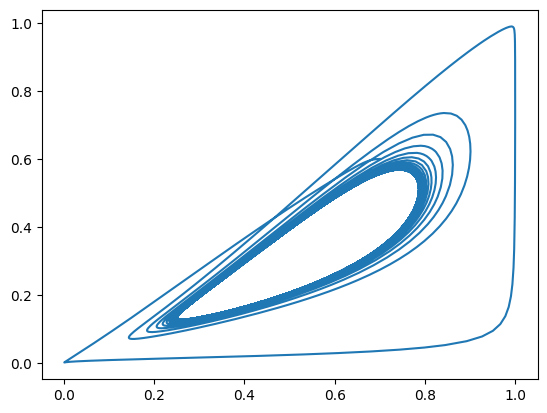

In [76]:
initialstate = [0.6,0.7, *f_of_x_vec]
t_f=5000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
plt.plot(out2.y[1],out2.y[0])


In [77]:
N1, N2 = out2.y[0:2]

In [104]:
f_of_x_vec = out2.y[2:]
x_vec = np.arange(1,11,1)
p = np.sum(x_vec*f_of_x_vec.T,1)
mean_group_size_membership(f_of_x_vec.T, x_max, p)

In [79]:
numerator[mask,:]

array([[2.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.99999368e+01, 1.26489906e-04, 9.01891953e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.99998735e+01, 2.52978610e-04, 2.70565887e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.92189508e-01, 8.46639444e-01, 4.21361461e+00, ...,
        2.41786590e-05, 5.52265317e-07, 1.10771603e-08],
       [1.90486897e-01, 8.70369392e-01, 4.34935728e+00, ...,
        2.42793046e-05, 5.40962116e-07, 1.05850315e-08],
       [1.89447501e-01, 8.79945038e-01, 4.40146916e+00, ...,
        2.40941025e-05, 5.31005384e-07, 1.02767071e-08]])

In [99]:
f_of_x_vec = out2.y[2:]

x_vec = np.arange(1,11,1)
p = np.sum(x_vec*f_of_x_vec.T,1)
f_of_x_vec = f_of_x_vec.T
mask = p > 1e-10
numerator = x_vec*(f_of_x_vec*x_vec)
numerator = numerator.sum(1)
ans = p.copy()
ans[mask] = numerator[mask]/p[mask]
ans[~mask] = np.nan

In [100]:
ans

array([1.        , 1.00000316, 1.00000632, ..., 3.37847251, 3.39481372,
       3.39994785])

In [89]:
numerator.sum(1)

array([20.        , 20.00006325, 20.00012649, ..., 14.52449726,
       15.27865848, 15.54497793])

In [86]:
ans_to_sum = p.copy()
ans_to_sum[mask,:] = numerator[mask,:].T/p[mask]
ans_to_sum[~mask,:] = np.nan

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [66]:
mask = p > 1e-10

In [67]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [41]:
frequency_in_group_size_x = (f_of_x_vec.T*x_vec).T/p

In [43]:
vec_to_sum = x_vec*frequency_in_group_size_x.T

In [12]:
x_vec = np.arange(1,x_max+1,1)
    
    frequency_in_group_size_x = (f_of_x_vec*x_vec).T/p
    vec_to_sum = x_vec*frequency_in_group_size_x.T
    if len(vec_to_sum.shape) > 1:
        return vec_to_sum.sum(1)
    else:
        return sum(vec_to_sum)

array([], dtype=float64)

In [10]:
out2.y[1,

np.float64(0.9999937033254204)

In [214]:
P,N1,N2 = out2.y[0:3]
f_of_x_vec = out2.y[3:]

In [215]:
xvec = np.arange(1,11)